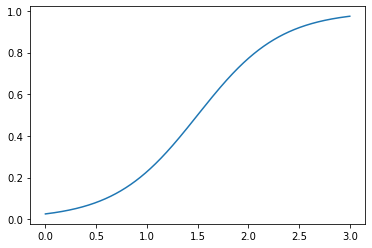

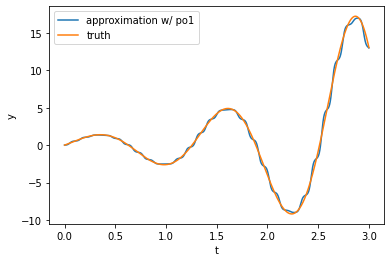

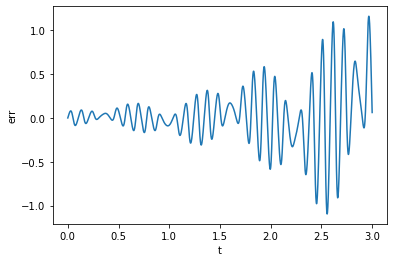

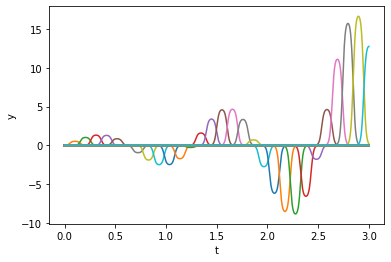

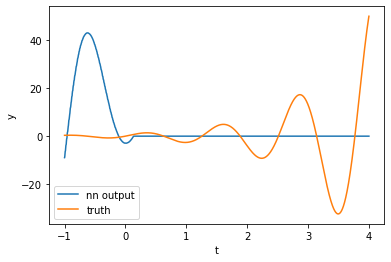

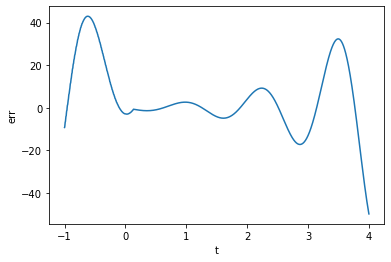

In [15]:
import numpy as np 
import pandas as pd 
import numpy.linalg as la 
import numpy.matlib
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

### You  will not use MLPipeline in this assignment;
## we're including it for reference because you will be using 
# it soon enough, and also another class inherits from it 
class MLPipeline:
    def __init__(self,epochs = 250,lr = 0.025):
        ###In this constructor we set the model complexity, number of epochs for training, 
        ##and learning rate lr. You should think of complexity here as "number of parameters"
        #defining model. In linear regression, this e.g. may be (deg of poly)-1. 
        self.epochs = epochs
        self.lr = lr 

    def gen_data(self,):
        raise NotImplementedError

    def loss(self,):
        raise NotImplementedError

    def forward(self,):
        raise NotImplementedError

    def backward(self,):
        raise NotImplementedError 

    def update(self,):
        raise NotImplementedError  

    def metrics(self,x,y):
        raise NotImplementedError     

    def fit(self,x_data,y_data,x_eval,y_eval, printing = False):
        ### This method implements our "1. forward 2. backward 3. update paradigm"
        ## it should call forward(), grad(), and update(), in that order. 
        # you should also call metrics so that you may print progress during training
        if printing:
            self.x_eval = x_eval 
            self.y_eval = y_eval
        for epoch in range(self.epochs):
            y_pred = self.forward(x_data)
            loss = self.loss(y_pred,y_data)
            grad = self.backward(x_data,y_data)
            self.update(grad)
            if printing: 
                m = self.metrics(x_eval,y_eval)
                if epoch % 100 == 0:
                    print(f"epoch {epoch} and train loss {loss.mean():.2f}, test metrics {m:.2f}")
        if printing:
            self.m = m


class UniversalApprox:
    def __init__(self,epsilon=0.01,fun = None):
        self.eps = epsilon
        if fun == None:
            ### you are welcome to define your own custom function 
            self.fun = self.wiggles_fun
        else:
            self.fun = fun 

    def sigma(self,t,a=1,b=0,):
        ''' 
            This way of expressing sigmoidal is to facilitate 
            solve_ab, to make transparent ''linearity'' wrt unknowns
            You may not even need to use solve_ab, in the event you 
            work out simpler math yourself (cf class)
        '''
        s = 1/(1+np.exp(-(t-b)/a))
        return s 
    
    def solve_ab(self,x,y):
        ## solves for a,b in sigma above 
        # ensure you understand how / what this solves for
        l0 = y[0]/(1-y[0])
        l1 = y[1]/(1-y[1])
        A = np.array([[np.log(l0), 1],[np.log(l1),1]])
        b = np.array([[x[0]],[x[1]]])
        sol = np.linalg.inv(A) @ b 
        return sol
    
    def find_nn_params(self,t_in,fun,j_ext =10): 
        ''' 
            This method finds the a and bs for sigmoidals which can be used 
            for po1 approximate (bump functions in programming assignment)
            You should return 
                1. your domain-extended input array (need to extend domain for po1 to cover)
                2. function evaluations at bump function's apex 
                3. array of a,b parameters defining the bump functions
        '''
        t_min, t_max = t_in[0], t_in[1]
        t_in_ext = np.linspace(t_min - t_in[j_ext], t_in[-1] + (t_in[j_ext]-t_min), t_in.shape[0] + int(2*j_ext)) #extended array
        f_xi = self.fun(t_in_ext)
        n = t_in_ext.shape[0]
        param = np.zeros((len(f_xi),2))
        delta = t_max - t_min
        for i in range(len(t_in_ext)):
            x = np.array([t_in_ext[i], t_in_ext[i]-delta/2])
            y = np.array([1-self.eps/2, 0.5])
            coef = self.solve_ab(x, y)
            param[i] =  coef.reshape((1, 2)) #array of the coefficients      
        return t_in_ext, f_xi, param

    def approx_fun(self,t_in,fun,j_ext = 10,t_eval = None):
        ''' 
            This method uses the bump function parameters you computed 
            from find_nn_parameters, and returns a function's approximation as 
            y(x) = sum_i y(x_i)bump(x) (where sum is over sampled values)
            returns 
                1. t_space (filtered)
                2. y approximation evaluated on t_space
                3. individual y approximation bumps, as large array 
                    (see figure from programming assignment)
            There's a subtle point with t_eval: you will compute approximation based on t_in, 
            which will likely have courser granularity than t_eval. Because you may want something smooth looking, 
            you'll use t_eval to plot *output*
        '''
        t_ext, f_xi, params = self.find_nn_params(t_in,fun,j_ext =10) 
        if t_ext is not None:
            t_ext = t_eval
        y = np.zeros(t_ext.shape[0])
        y_total = np.zeros([t_ext.shape[0], f_xi.shape[0]])
        n = f_xi.shape[0]
        for i in range(n-1):
            diff = f_xi[i] * (self.sigma(t_ext,params[i,0],params[i,1]) - self.sigma(t_ext,params[i+1,0],params[i+1,1]))
            y_total[:,i] = diff    
            y = y + diff
        return t_ext, y, y_total  

    def wiggles_fun(self,t):
        return np.sin(5*t)*np.exp(t)


class UANet(MLPipeline):
    def __init__(self,params):
        super().__init__()
        ''' 
            Instantiation of this class will likely be your biggest headache. You need to make sure you 
            take parameters and align / shape them correctly for your network. Will need weights, biases, 
            and function sampled evaluations (which you get from UniversalApprox.find_nn_params); just make 
            sure that you process and store them correctly!
            Aside from hashing out the constructor, you will only need to implement the forward method for this 
            class, how simple!
        ''' 
        w_temp = -1/params[0] 
        b_temp = params[1] * w_temp
        f_temp = params[2]
        self.weights = w_temp.reshape((w_temp.shape[0], 1))
        self.bias = b_temp.reshape((b_temp.shape[0], 1))
        self.f_val = f_temp.reshape((f_temp.shape[0], 1))

    def forward(self,x):
        ## computes the forward pass for network x -> z = wx+b -> a = sigm(z) -> c*a
        z = self.weights @ x + self.bias
        a = self.sigmoid(z)
        f = self.f_val.transpose() @ a
        return f.reshape(f.shape[1])

    def backward(self,x_in,y_truth):
        ## Do not implement
        return None 

    def update(self,grad):
        ## Do not implement
        return None 

    def metrics(self,x,y):
        ## Do not (need to) implement
        return None

    def sigmoid(self,z):
        ## Already implemented for you
        return 1/(1+np.exp(-z))
    
    def loss(self,x_in,y_truth):
        ### calculating loss using partial as initial computation
        ## Do not implement
        return None

    def l_grad(self,x_in,y_truth):
        ## Do not implement
        return None




if __name__ == "__main__":
    plotting = True
    ## Step 1: instantiate your UniversalApprox Object
    eps = .025
    ua = UniversalApprox(epsilon = eps)
    x_lim = 3
    ### Step 2: Generate approximations with po1
    ## If you use my wiggles_fun, it has an exp, so don't go wild on your domain
    # need sample linspace for function approximation, and denser linspace for evaluation

    t_space = np.linspace(0,x_lim,30)
    t_dense = np.linspace(0,x_lim,2500)
    
    ###2.a: check the a,b solve
    ## expect y values of sigmoidal to correspond to those provided (y_points)
    # at specified x values (x_points). Play around with this until you understand it
    x_points = np.array([0,3])
    y_points = np.array([eps,1-eps])
    ab = ua.solve_ab(x_points,y_points)
    sigm = ua.sigma(t_dense,ab[0],ab[1])
    plt.figure(0)
    plt.plot(t_dense,sigm)



    ### 2.b, th bulk of your work will be here: define the approximation method using 
    ## c-inf bump functions, as defined by successive differences of sigmoidals
    t_eval, y_approx,y_incs  = ua.approx_fun(t_space,ua.wiggles_fun,t_eval = t_dense)
    y_truth = ua.fun(t_eval)
    y_err = y_truth - y_approx
   
    if plotting: 
        plt.figure(1)
        plt.plot(t_eval,y_approx,label = 'approximation w/ po1')
        plt.plot(t_eval,y_truth, label = 'truth')
        plt.legend()
        plt.xlabel('t')
        plt.ylabel('y')
        plt.figure(2)
        plt.plot(t_eval,y_err)
        plt.xlabel('t')
        plt.ylabel('err')
        plt.figure(3)
        for j in range(y_incs.shape[1]):
            plt.plot(t_eval,y_incs[:,j])
        plt.xlabel('t')
        plt.ylabel('y')


    ## Step 3: Extract weights for Neural Net and instantiate object
     
    _,s,ab = ua.find_nn_params(t_in = np.linspace(0,x_lim,250),fun = ua.wiggles_fun,)
    params = [ab[:,0],ab[:,1],s]
    nn = UANet(params)

    ### Step 4: Check nn approximation
    ## extending domain to show that the nn will only work for the domain of approximations 
    # you found earlier
     
    t_space = np.linspace(-1,x_lim+1,10000)
    y_nn = nn.forward(t_space.reshape((1,t_space.shape[0])))
    y_truth = ua.fun(t_space)
    err = y_nn - y_truth
    
    if plotting:
        plt.figure(4)
        plt.plot(t_space,y_nn,label = 'nn output')
        plt.plot(t_space,y_truth,label = 'truth')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend()
        plt.figure(5)
        plt.plot(t_space,err)
        plt.xlabel('t')
        plt.ylabel('err')
        plt.show()

   